<a href="https://colab.research.google.com/github/xinconggg/Machine-Learning/blob/main/Ensemble%20Learning%20and%20Random%20Forests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Voting Classifiers

In [1]:
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

voting_clf = VotingClassifier(
    estimators=[
        ("lr", LogisticRegression(random_state=42)),
        ("rf", RandomForestClassifier(random_state=42)),
        ("svc", SVC(random_state=42))
    ]
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

Look at each fitted classifier's accuracy on the test set:

In [2]:
for name, clf in voting_clf.named_estimators_.items():
  print(name, "=", clf.score(X_test, y_test))

lr = 0.864
rf = 0.896
svc = 0.896


Hard voting would be performed when voting classifier's predict() method is called.

In [3]:
[clf.predict(X_test[:1]) for clf in voting_clf.estimators_]

[array([1]), array([1]), array([0])]

In [4]:
voting_clf.predict(X_test[:1])

array([1])

Since 2 out of the 3 classifiers predicted class 1 for the instance of the test set, the voting classifier class predicted 1 as well.

Accuracy of the voting classifier on test set:

In [5]:
voting_clf.score(X_test, y_test)

0.912

The voting classifier outperforms all the individual classifiers.

```Soft voting``` occurs when all classifiers are able to estimate class probabilities and when Scikit-Learn is used to predict the class with the highest class probability, averaged over all the individual classifiers. <br>
```Soft voting``` usually outperforms ```Hard voting ``` since more weight is assigned to highly confident votes.

In [6]:
voting_clf.voting = "soft"
voting_clf.named_estimators["svc"].probability = True
voting_clf.fit(X_train, y_train)
voting_clf.score(X_test, y_test)

0.92

92% accuracy is achieved using ```Soft voting```.

## Bagging and Pasting

```Bagging``` is a method where sampling is performed **with** replacement, whereas ```pasting``` is a method where sampling is performed **without** replacement. <br>
Both ```Bagging``` and ```Pasting``` allow training instances to be sampled several times across multiple predictors but only ```Bagging``` allows training instances to be sampled several times across the same predictor.

The following code trains an ensemble of
500 decision tree classifiers: each is trained on 100 training instances randomly
sampled from the training set with replacement using ```Bagging```. ```Pasting``` can be done by setting "bootstrap = False".

In [7]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(),
                            n_estimators=500,
                            max_samples=100,
                            n_jobs=-1,
                            random_state=42)
bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, random_state=42)

```Bagging``` typically ends uo with a slightly higher bias than ```Pasting``` since ```Bagging``` introduces more diversity in the subsets that each predictor is trained on, hence ending up with a slightly higher bias than ```Pasting```. However, the extra diversity means that the predictors end up being less correlated hence the ensemble's variance is reduced. <br>
Overall, ```Bagging``` often results in better models. However, both methods can be evaluated using cross-validation to choose the better-performing method.

### Out-of-Bag Evaluation
Some training instances may be sampled several times for any given predictor, while others may not be sampled at all during ```Bagging```. ```Out-of-Bag``` (OOB) instances are training instances that are not sampled. when "oob_score = True" OOB evaluation would be done after training.

In [8]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(),
                            n_estimators=500,
                            oob_score=True,
                            n_jobs=-1,
                            random_state=42)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.896

According to the OOB evaluation, the BaggingClassifier is likely to achieve about 89.6% accuracy on the test set. <br> Verify:

In [9]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.92

The classification has an accuracy of 92% on the test set.

The class probabilities for each training instance can be determined using the decision function.

In [10]:
bag_clf.oob_decision_function_[:3] # probas for the first 3 instances

array([[0.32352941, 0.67647059],
       [0.3375    , 0.6625    ],
       [1.        , 0.        ]])

## Random Forests

Random forest is an ensemble of decision trees, generally trained via the ```bagging``` method, typically with *max_samples* set to the size of the training set. <br> The following code trains a random forest classifier with 500 trees, each limited to a maximum of 16 leaf nodes.

In [11]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500,
                                 max_leaf_nodes=16,
                                 n_jobs=-1,
                                 random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

*RandomForestClassifier* has all the hyperparameters of a *DecisionTreeClassifer* plus all the hyperparameters of a *BaggingClassifier* to control the ensemble itself.

## Boosting

Refers to any ensemble method that can combine several weak learners into a strong learner. The general idea of ```boosting``` is to train predictors sequentially, each trying to correct its predecessor. The most popular ```boosting``` methods are *AdaBoost* and *Gradient boost*.

### AdaBoost

By focusing more on the training instances that its predecessor underfitted, a new predictor can correct its predecessor. This technique is used by AdaBoost.

When training an AdaBoost classifier, the algorithm first trains a base
classifier (such as a decision tree) and uses it to make predictions on the training set.
The algorithm then increases the relative weight of misclassified training instances.
Then it trains a second classifier, using the updated weights, and again makes
predictions on the training set, updates the instance weights, and so on

In [12]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=30,
    learning_rate=0.5,
    random_state=42
)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=30, random_state=42)

### Gradient Boosting
Similar to AdaBoost, gradient boosting works by sequentially adding predictors to an ensemble, with each one correcting its pre-decessor. However, instead of tweaking the instance weights at every integration like AdaBoost, this method tries to fit the new predictor to the *residual errors* made by the previous predictor.
  
Below is a simple regression example, using decision trees as the base predictors, also known as *Gradient Tree Boosting* or *Gradient Boosted Regression Tree* (GBRT). First, generate a noisy quadratic dataset and fit a ```DecisionTreeRegressor``` to it:

In [13]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)
X = np.random.rand(100,1) - 0.5
y = 3 * X[:,0] ** 2 + 0.05 * np.random.randn(100) # y = 3X^2 + Gaussian noise

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

Next, train a second ```DecisionTreeRegressor``` on the residual errors made by the first predictor:

In [14]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=43)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=43)

Then, train a third regressor on the residual errors made by the second predictor:

In [15]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=44)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=44)

Now, the ensemble contains 3 trees. It can make predictions on a new instance simply by adding up the predictions of all the trees:

In [16]:
X_new = np.array([[-0.4], [0.], [0.5]])
sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

array([0.49484029, 0.04021166, 0.75026781])

#### Using Scikit-Learn to train GBRT

In [17]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3,
                                 learning_rate=1.0, random_state=42)
gbrt.fit(X,y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

To find the optimal number of trees, perform cross-validation using ```GridSearchCV``` or ```RandomizedSearchCV``` as usual. However, there's a simpler way: if the *n_iter_no_change* hyperparameter is set to an integer value, say 10, then the ```GradientBoostingRegressor``` will automatically stop adding more trees during training if the last 10 trees didn't help.

In [18]:
gbrt_best = GradientBoostingRegressor(
    max_depth=2, learning_rate=0.05, n_estimators=500,
    n_iter_no_change=10, random_state=42)
gbrt_best.fit(X,y)

GradientBoostingRegressor(learning_rate=0.05, max_depth=2, n_estimators=500,
                          n_iter_no_change=10, random_state=42)

In [19]:
gbrt_best.n_estimators_

92

## Stacking
Short for Stacked Generalization, it is based on a simple idea. Instead of using trivial functions such as hard voting to aggregate the predictions of all predictors in an ensemble, a model is trained to perform this aggregation.
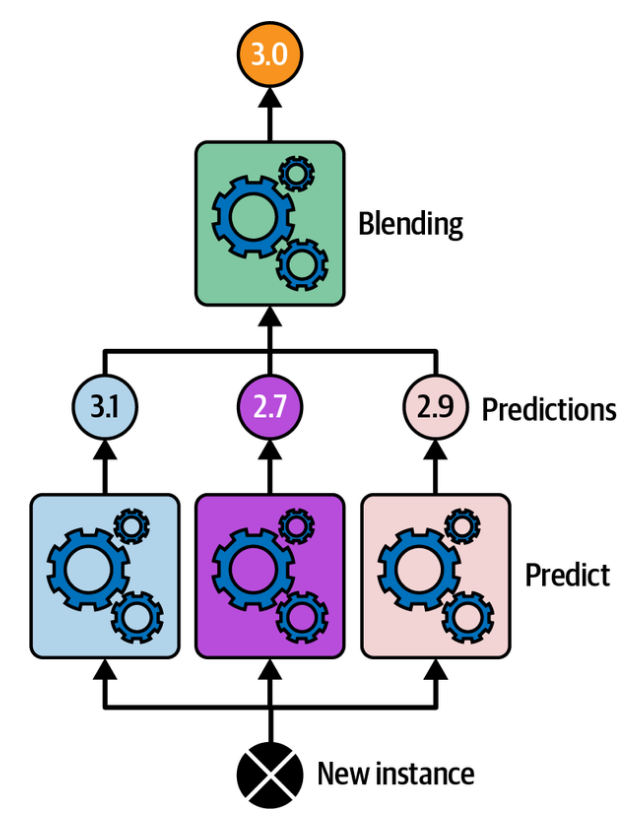

Scikit-Learn provides 2 classes for stacking ensembles: ```StackingClassifier``` and ```StackingRegressor```.

In [20]:
from sklearn.ensemble import StackingClassifier

stacking_clf = StackingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(probability=True, random_state=42))
    ],
    final_estimator=RandomForestClassifier(random_state=43),
    cv=5  # number of cross-validation folds
)
stacking_clf.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('lr', LogisticRegression(random_state=42)),
                               ('rf', RandomForestClassifier(random_state=42)),
                               ('svc', SVC(probability=True, random_state=42))],
                   final_estimator=RandomForestClassifier(random_state=43))

For each predictor, the stacking classifier will call ```predict_proba()``` if available. If not, it will fall back to ```decision_function()``` or as a last resort, will call ```predict()```. If a final estimator is not provided, *StackingClassifier* will use *LogisticRegression* and *StackingRegressor* will use *RidgeCV*.